In [2]:
%pylab inline

from jla_data_fix import *
import scipy.integrate as si
import lmfit

speed_of_light, hubble_constant = 3e08, 2e-18

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [3]:
params = lmfit.Parameters()

params.add('lpeak', value=4.1e39, vary=True)
#omegas
params.add('omega', value=1., vary=False)
params.add('c', value=0., vary=False, min=0.)  # degenerate with b
params.add('b', value=0.27, vary=True, min=0.)
params.add('rad', value=0., vary=False, min=-1., max=1.)
params.add('k', value=0., vary=False, max=1., min=-1)
params.add('de', value=0.73, vary=True, min=0., max=1., expr="omega-b-k-rad")
params.add('w', value=-1, vary=False)  # don't move me man

In [4]:
def friedmann(z, params):
    model = (params['c'].value + params['b'].value) * ((1+z)**3) + params['rad'].value * ((1+z)**4) + params['k'].value * ((1+z)**2) + params['de'].value * ((1+z)**(3*(1 + params['w'].value)))
                
    return np.sqrt(model)

In [5]:
def sk_integrand(z, params):
    return 1/friedmann(z, params)

In [6]:
def sk_integral(z, params):
    oarray = empty_like(z)
    
    for i in range(len(z)):
        output = si.quad(sk_integrand, 0, z[i], args=(params))
        oarray[i] = output[0]
        
    return oarray

In [7]:
def comoving(z, params):
    omegak = params['k'].value
    this_int = sk_integral(z, params)
    k_precision = 1E-9
    
    if -k_precision < omegak < k_precision:
        factor = this_int
    elif omegak < -k_precision:
        factor = (1/np.sqrt(omegak))*np.sin((np.sqrt(omegak))*this_int)
    elif omegak > k_precision:  # omegak > 0 and other edge cases, doesn't really matter
        factor = (1/np.sqrt(omegak))*np.sinh((np.sqrt(omegak))*this_int)
        
    return factor * (speed_of_light/hubble_constant)

In [8]:
def mag_of_f(f, m0=-20.45):
    """Implementation of (3) at the top. Returns magnitude as a function of flux
    Assumes f given in cgs units"""
    return m0 - 2.5*np.log10(1E-4*f)  # factor to deal with units

In [9]:
def f_of_z(z, params):
    return params['lpeak'].value/(4*np.pi*(comoving(z, params)*(1+z))**2)

In [10]:
def chisq(obs, exp, err):
    """Returns the chi squared as in (5) top writing."""
    return ((obs-exp)**2/(err**2))

In [11]:
def for_fitting(params, z, data, errors):
    return chisq(mag_of_f(f_of_z(z, params)), data, errors)

In [12]:
allz = hstack(zs)  # remove per-survey
allmsb = hstack(msbs)
allmsbe = hstack(msbes)

out = lmfit.minimize(for_fitting, params, args=(allz, allmsb, allmsbe), method='leastsq')

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # function evals   = 36
    # data points      = 740
    # variables        = 2
    chi-square         = 106302.680
    reduced chi-square = 144.042
[[Variables]]
    lpeak:   4.0972e+39 +/- 7.04e+37 (1.72%) (init= 4.1e+39)
    omega:   1 (fixed)
    c:       0 (fixed)
    b:       0.45947915 +/- 0.035809 (7.79%) (init= 0.27)
    rad:     0 (fixed)
    k:       0 (fixed)
    de:      0.54052084 +/- 0.035809 (6.63%)  == 'omega-b-k-rad'
    w:      -1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(lpeak, b)                  = -0.870 


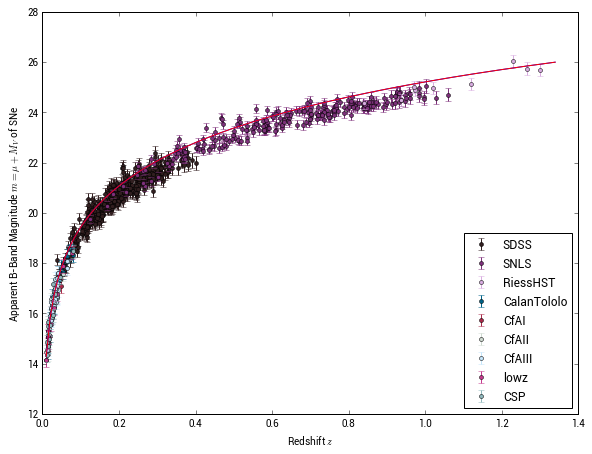

In [15]:
figure(figsize=(9.6, 7.2))

matplotlib.rc('font', family='Roboto') 
matplotlib.rc('font', serif='Roboto') 

for i in range(len(surveys)):
    survey = surveys[i]
    color = ducolors[i]
    thisz = zs[i]
    thismsb = msbs[i]
    thismsbe = msbes[i]
    
    errorbar(thisz,
             thismsb,
             yerr=thismsbe*2,
             color=color,
             fmt='o',
             ms=4,
             label=survey) 

legend(loc=4, numpoints=1)

params['lpeak'].value = 3.64e39
params['b'].value = 0.30
params['de'].value = 0.70

plot(np.arange(0, 1.35, 0.01), mag_of_f(f_of_z(np.arange(0, 1.35, 0.01), params)), color='b')

#plot u2.1


plot(np.arange(0, 1.35, 0.01), mag_of_f(f_of_z(np.arange(0, 1.35, 0.01), params)), color='r')


ylabel('Apparent B-Band Magnitude $m = \mu + M_V$ of SNe')
xlabel('Redshift $z$')